# All code and junk that did not fit into the report

## Intro kinda

$$R(h) = \mathbf{E}_{x, y \sim D} [L(h(x), y)]$$
$$\widehat{R}(x) = \frac{1}{m}\sum_{i = 1}^{m}L(h(x_i), y_i)$$

The optimiztion for LASSO can be writen in two forms as:

$$\min_{w, b}F(w, b) = \lambda \|w\|_1 + \sum_{i = 1}^{m}(w \cdot x_i + b - y_i)^2)$$

$$\min_{w, b} (\sum_{i = 1}^{m}(w \cdot x_i + b - y_i)^2) \text{  |  } \|w\|\leq Λ_1$$


**Theorem 11.16:** Let $\mathcal{X} \in \mathbb{R}^N$ and $\mathcal{H} = \{x \in \mathcal{X} \rightarrow w \cdot x: \|w\|_1 \leq Λ_1\}$. Assume that there exists $r_{\infty} > 0$ such for all $x \in \mathcal{X}$, $\|x\|_{\infty} \leq r_{\infty}$ and $M>0$ such that $|h(x) - y| \leq M$ for all $(x, y)\in \mathcal{X} \times \mathcal{y}$. Then for any $δ>0$, with probability at least $1-\delta$, each of the following inequalities hold for all $h \in \mathcal{H}$:
$$R(h) \leq \widehat{R}(h) + 2r_{\infty}\Lambda_{1}M\sqrt{\frac{2\log{2N}}{m}} + M^{2}\sqrt{\frac{log{\frac{1}{\delta}}}{2m}}$$

## Part 1: Error bound on synthetic data

In [12]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import io
import random
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

In [2]:
loc = 'C:/Users\Arthur\Desktop\Study\Fall2022'
os.makedirs(loc, exist_ok=True)

In [3]:
var = 1
r_inf = np.sqrt(3*var)

N0, Nk, Ns = 10, 100, 10
m0, mk, ms = 100, 1000, 100
alpha = [0.2, 0.5, 0.8, 1.1, 1.4]

t = 10 #number of random vectors to be tested for each dimensionality
k = 200 #number of training sets to determine quantiles, lambdas, maximum deviation

data = {"N":[], "try":[], "alpha":[], "m":[], "Lam":[], "dR0.1":[], "dR0.3":[], "dR0.5":[], "DevMax":[]}

for N1 in range(N0, Nk+1, Ns):
  for j in range(t):
    w_unif = np.random.uniform(-1, 1, N1)
    for a in alpha:
      clf = Lasso(alpha = a)
      for m in range(m0, mk+1, ms):
        CNZ = []
        M = np.zeros(k)
        R_appr = np.zeros(k)
        R_true = np.zeros(k)
        for i in range(k):
          X_train = np.random.uniform(-r_inf, r_inf, (m, N1))
          Y_train = X_train@w_unif
          clf.fit(X_train, Y_train)
          CNZ.append(np.count_nonzero(clf.coef_))
          R_appr[i] = (np.linalg.norm(X_train@clf.coef_ - Y_train, ord = 2)**2)/m
          R_true[i] = var*np.linalg.norm(clf.coef_ - w_unif, ord = 2)**2
          M[i] = r_inf*np.linalg.norm(clf.coef_ - w_unif, ord = 2)
          
        data["N"].append(N1)
        data["try"].append(j)
        data["alpha"].append(a)
        data["m"].append(m)
        data["Lam"].append(np.max(CNZ))
        data["dR0.1"].append(np.quantile(R_true - R_appr, 0.9))
        data["dR0.3"].append(np.quantile(R_true - R_appr, 0.7))
        data["dR0.5"].append(np.quantile(R_true - R_appr, 0.5))
        data["DevMax"].append(np.max(M))
        
data3 = pd.DataFrame(data)
data3.to_csv('C:/Users\Arthur\Desktop\Study\Fall2022\out.csv')

In [222]:
data3 = pd.read_csv('C:/Users\Arthur\Desktop\Study\Fall2022\out.csv')

In [223]:
data3["dR0.1*srm"] = data3["dR0.1"]*np.sqrt(data3["m"])
data3["dR0.3*srm"] = data3["dR0.3"]*np.sqrt(data3["m"])
data3["dR0.5*srm"] = data3["dR0.5"]*np.sqrt(data3["m"])

data3["dR0.1*m"] = data3["dR0.1"]*data3["m"]
data3["dR0.3*m"] = data3["dR0.3"]*data3["m"]
data3["dR0.5*m"] = data3["dR0.5"]*data3["m"]

data3["DevMax*m(1/4)"] = data3["DevMax"]*(data3["m"]**(1/4))

data3["Lam/N"] = data3["Lam"]/data3["N"]
data3["DevMax2/N"] = (data3["DevMax"]**2)/data3["N"]

data3["dR0.1/[N(3/2)sr(logN)]"] = data3["dR0.1"]/data3["N"]/np.sqrt(data3["N"]*np.log(data3["N"]))
data3["dR0.3/[N(3/2)sr(logN)]"] = data3["dR0.3"]/data3["N"]/np.sqrt(data3["N"]*np.log(data3["N"]))
data3["dR0.5/[N(3/2)sr(logN)]"] = data3["dR0.5"]/data3["N"]/np.sqrt(data3["N"]*np.log(data3["N"]))

data3["dR0.1/Lam"] = data3["dR0.1"]/data3["Lam"]
data3["dR0.3/Lam"] = data3["dR0.3"]/data3["Lam"]
data3["dR0.5/Lam"] = data3["dR0.5"]/data3["Lam"]

data3["DevMax2/Lam"] = (data3["DevMax"]**2)/data3["Lam"]
data3["dR0.1/alpha(3/2)"] = data3["dR0.1"]/np.sqrt(data3["alpha"]**3)

### Part 1.1: dR vs m

**Definition 1.1:** For fixed $m$ and $N$, $\hat{\Lambda}$ is the highest number of nonzero weights in the predicted weight vector across all generated samples.

**Proposition 1.2:** Let $N$ be fixed, then for a high enough $m$, the $\hat{\Lambda}$ is constant.

Justification: Given enough training data, learner should converge to an approximately the same set of featues it "deems" important, hence the number of those features should be the same across all predicted weight vectors.

Empirical results on the graph below comply with Proposition 1.

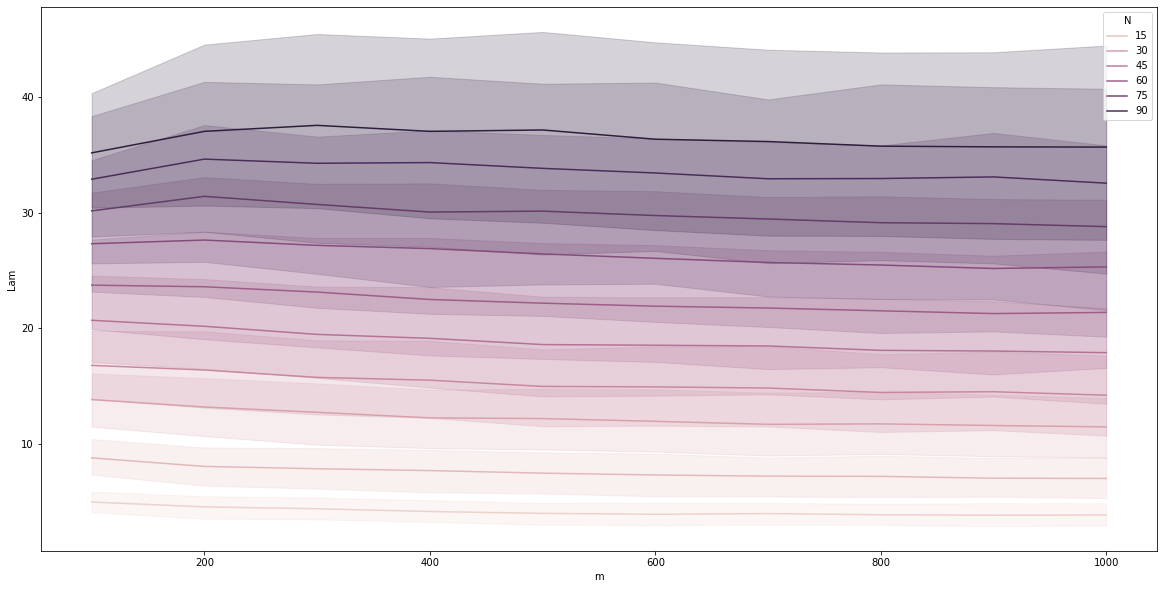

In [4]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = data3, x = "m", y = "Lam", hue = "N")

plt.show()

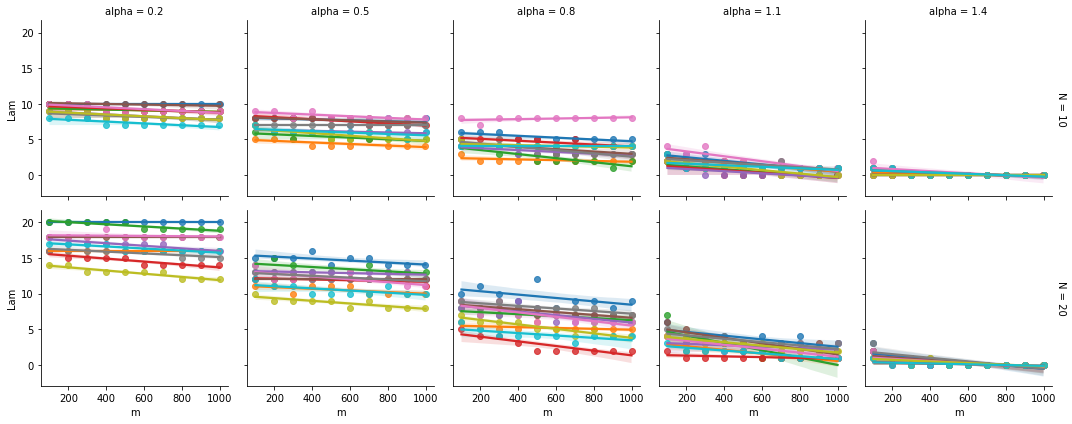

In [224]:
g = sns.FacetGrid(data3[(((data3["N"]<30)))], row = "N", col="alpha", margin_titles=True, hue = "try")
g.map(sns.regplot, "m", "Lam", fit_reg=True, x_jitter=.1)
plt.show()

**Definition 1.3:** For a fixed $N$ and $m$, let $\hat{M}$ be the maximum possible deviation of the predicted value across all generated samples for a given true weight vector.

**Proposition 1.4:** Let $N$ be fixed, then for a high enough $m$, the $\hat{M}$ is constant.

Justification: Given enough training data, the learner should converge to an approximately same set of good solutions with high probability, hence the maximum deviation of the predicted value should remain constant.

Empirical results on the graph below comply with Proposition 2.

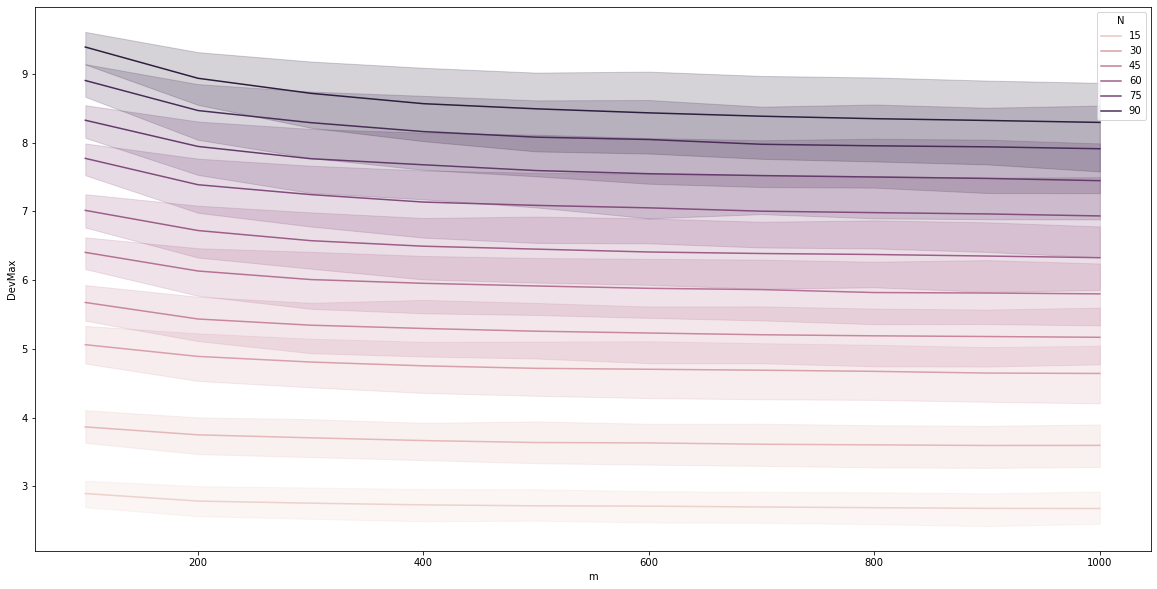

In [7]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = data3, x = "m", y = "DevMax", hue = "N")

plt.show()

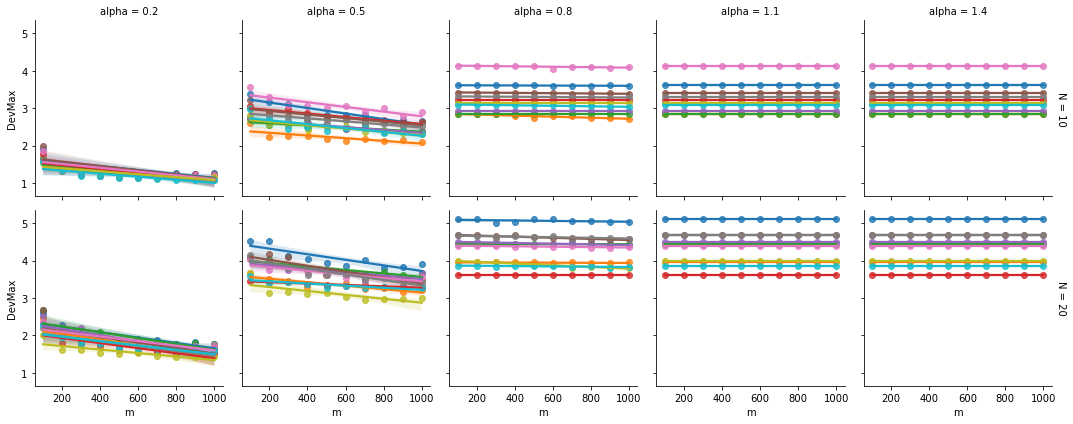

In [225]:
g = sns.FacetGrid(data3[data3["N"] < 30], col = "alpha", row = "N", hue = "try", margin_titles=True)
g.map(sns.regplot, "m", "DevMax", fit_reg=True, x_jitter=.1)
plt.show()

**Hypothesis 1:** When $m$ is high relative to $N$, $\delta R(h)$ depends linearly on $\sqrt{m}^{-1}$, i.e. $\delta R(h)*\sqrt(m)$ is constant across $m$.

The following 3 graphs show results for 3 different $\delta$ values. On each, the lines which correspond to the lower dimensions start to bottom out and behave like constant function with lower values of $m$. This result complies with the Hypothesis 1. This result is more evident on the grid figure: 

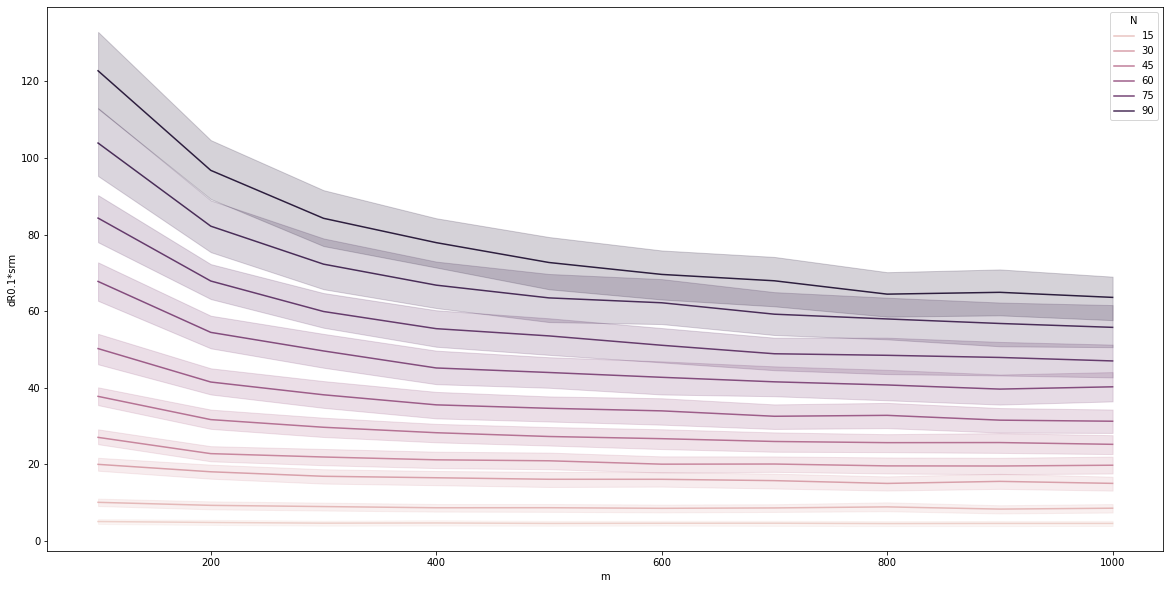

In [8]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = data3, x = "m", y = "dR0.1*srm", hue = "N")

plt.show()

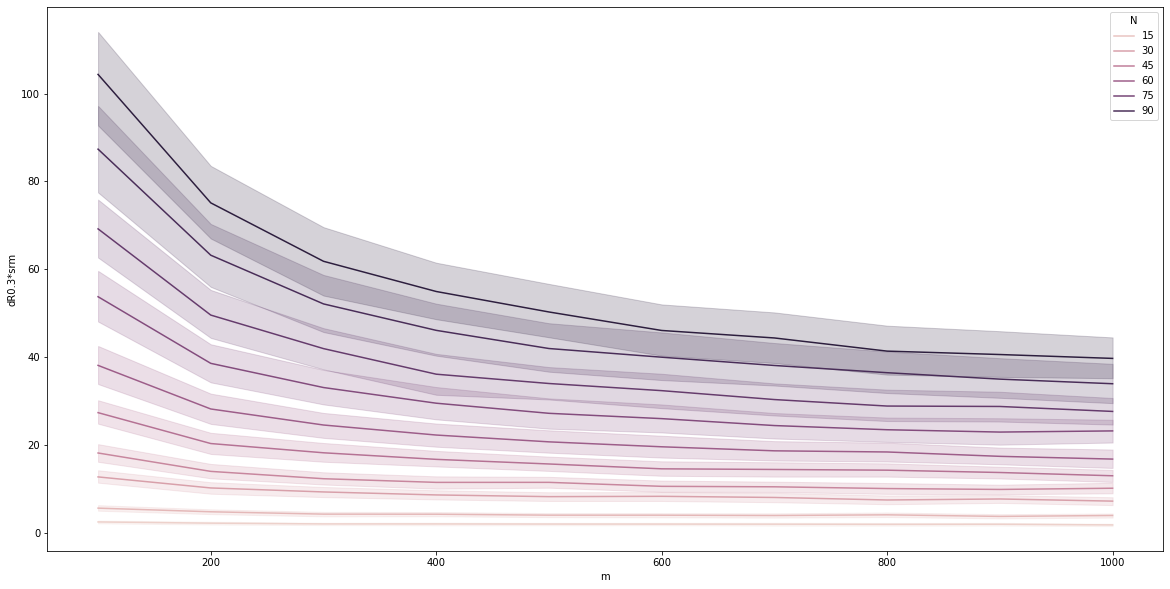

In [9]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = data3, x = "m", y = "dR0.3*srm", hue = "N")

plt.show()

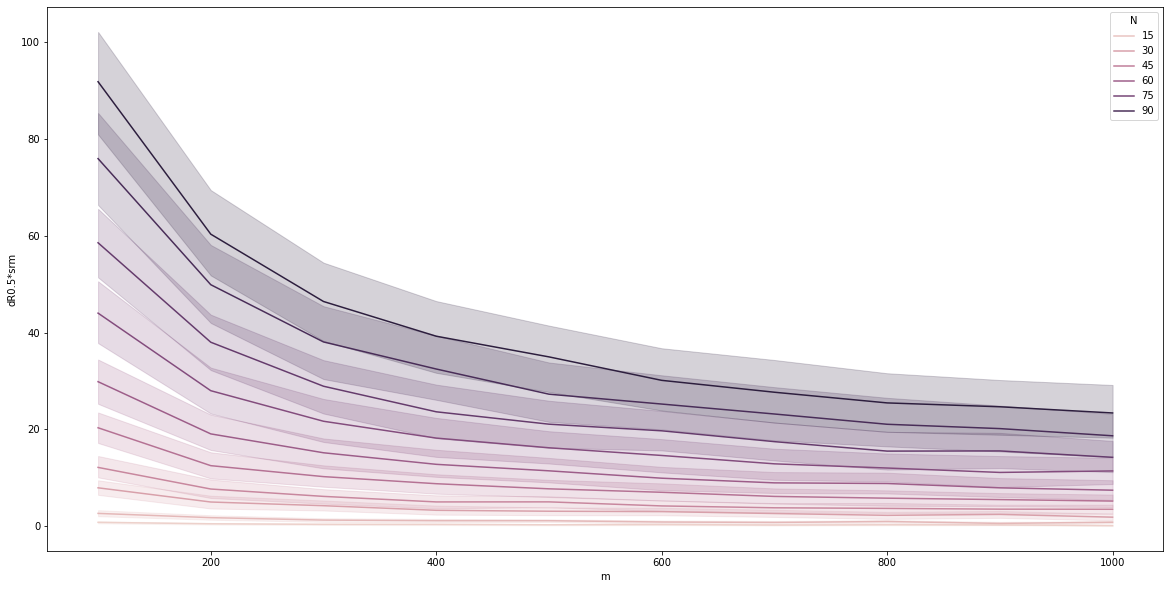

In [66]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = data3, x = "m", y = "dR0.5*srm", hue = "N")

plt.show()

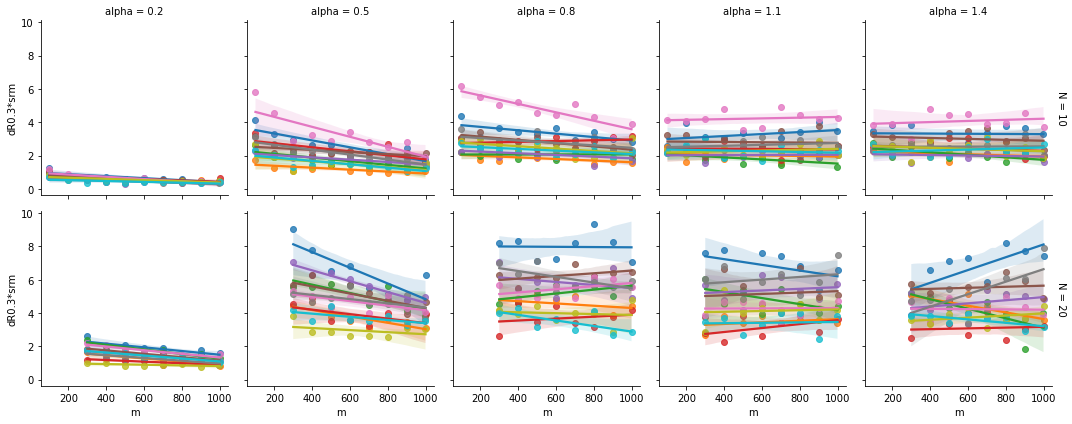

In [11]:
g = sns.FacetGrid(data3[((data3["N"] < 20) | ((data3["N"] < 30) & (data3["m"] > 250)))], row = "N", col="alpha", margin_titles=True, hue = "try")
g.map(sns.regplot, "m", "dR0.3*srm", fit_reg=True, x_jitter=.1)
plt.show()

### Part 1.2: dR vs N

**Proposition 2.1:** $\hat{M}^2$ (and $M$) depends linearly on $N$ given $m$ is high enough.

Justification: $M^2$ is the sum of squares of entries of some vector in $\mathbb{R}^{N}$, so it should depend lineraly on $N$.

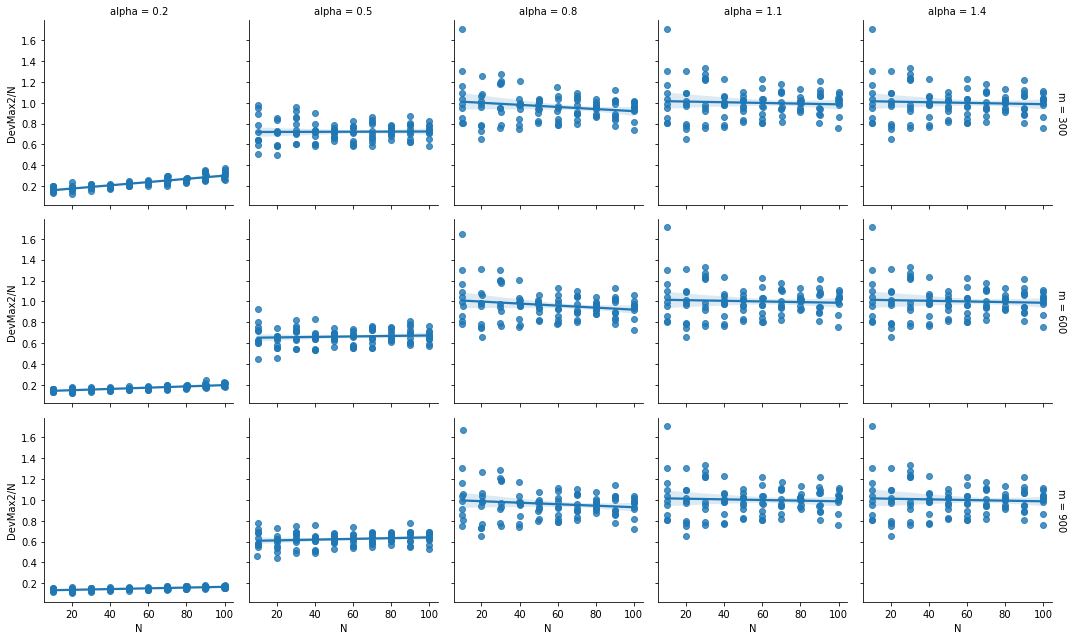

In [106]:
g = sns.FacetGrid(data3[(data3["m"]%300 == 0)], row="m", col="alpha", margin_titles=True)
g.map(sns.regplot, "N", "DevMax2/N", fit_reg=True, x_jitter=.1)
plt.show()

**Proposition 2.2:** $\hat{\Lambda}$ depends linearly on $N$ when $m$ is sufficient.

Justification: This follows from the first definition of LASSO regression. For high $m$, the squared loss on the training set caps out and from Proposition 2.1, it depends linearly on N. 

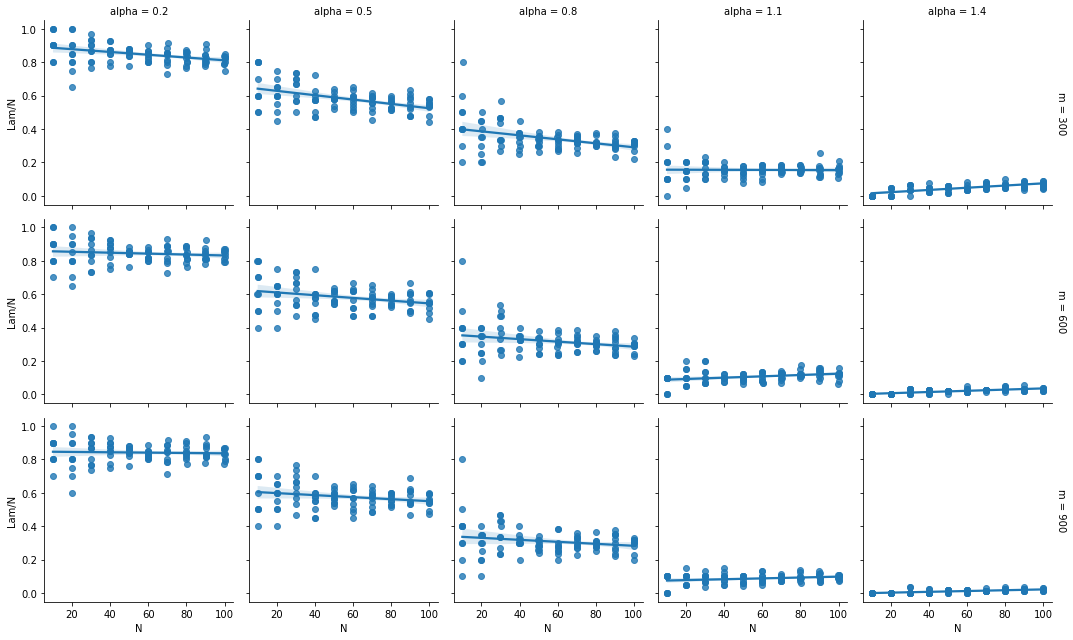

In [107]:
g = sns.FacetGrid(data3[(data3["m"]%300 == 0)], row="m", col="alpha", margin_titles=True)
g.map(sns.regplot, "N", "Lam/N", fit_reg=True, x_jitter=.1)
plt.show()

**Hypothesis 2:** $\delta R(h)$ depends linearly on $N^{3/2}\log{N}^{1/2}$, i.e. $\frac{\delta R(h)}{N^{3/2}\log{N}^{1/2}}$ is constant over $N$.

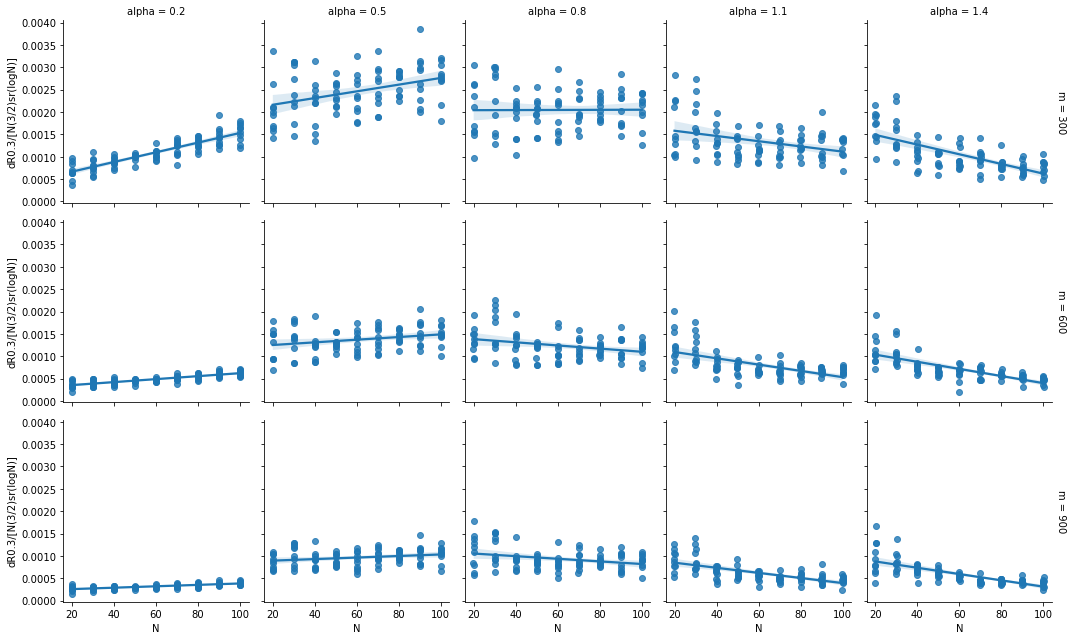

In [105]:
g = sns.FacetGrid(data3[(data3["m"]%300 == 0) & (data3["N"]>10)], row="m", col="alpha", margin_titles=True)
g.map(sns.regplot, "N", "dR0.3/[N(3/2)sr(logN)]", fit_reg=True, x_jitter=.1)
plt.show()

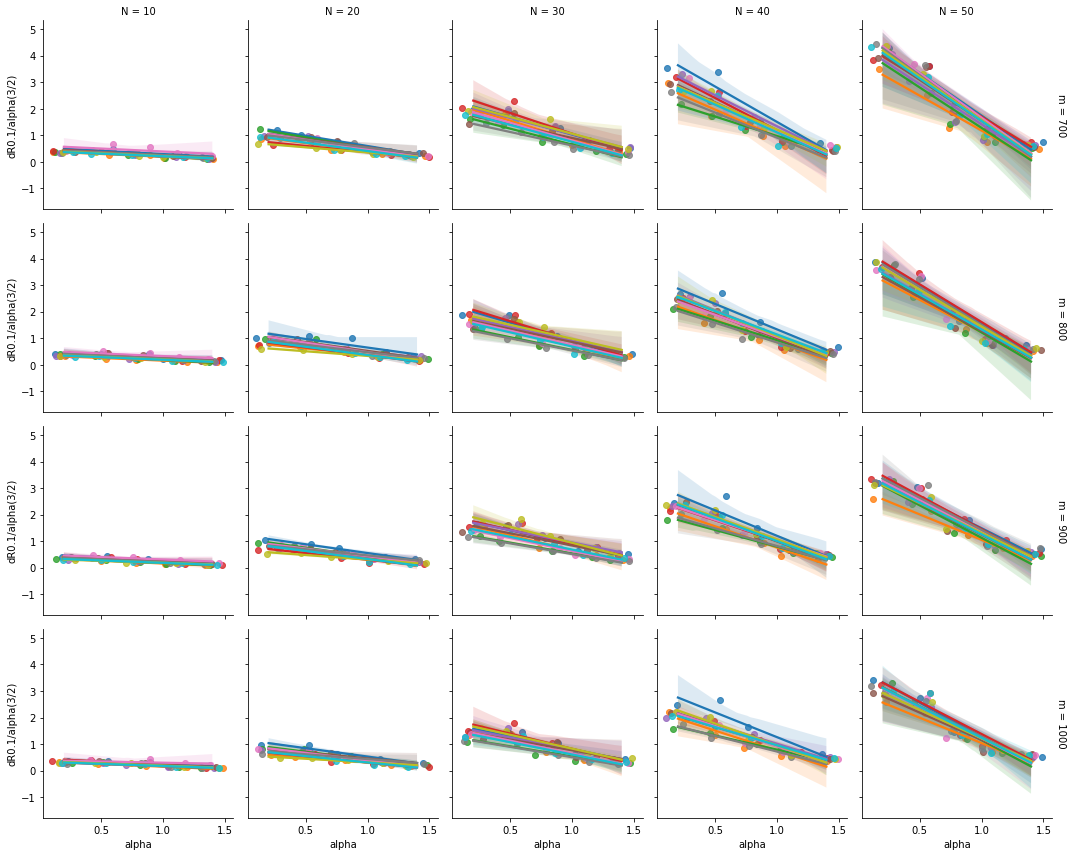

In [38]:
g = sns.FacetGrid(data3[(data3["m"]>600) & (data3["N"]<60)], col = "N", row = "m", hue = "try", margin_titles=True)
g.map(sns.regplot, "alpha", "dR0.1/alpha(3/2)", fit_reg=True, x_jitter=.1)
plt.show()

In [98]:
data4 = {"N":[], "try":[], "alpha":[], "m":[], "Lam":[], "dR0.1":[], "dR0.3":[], "dR0.5":[], "DevMax":[]}
Ns = [20, 40, 60, 80]
ms = [400, 600, 800]
alpha = (np.array(range(12))+6)/10
t = 10
k = 100
for N in Ns:    
    for j in range(t):
        w = np.random.uniform(-r_inf, r_inf, N)
        for a in alpha:
            clf = Lasso(a)
            for m in ms:
                nz = []
                M = np.zeros(k)
                R_appr = np.zeros(k)
                R_true = np.zeros(k)
                for i in range(k):
                    X = np.random.uniform(-r_inf, r_inf, (m, N))
                    Y = X@w
                    clf.fit(X, Y)
                    nz.append(np.count_nonzero(clf.coef_))
                    R_appr[i] = (np.linalg.norm(X@clf.coef_ - Y, ord = 2)**2)/m
                    R_true[i] = var*np.linalg.norm(clf.coef_ - w, ord = 2)**2
                    M[i] = r_inf*np.linalg.norm(clf.coef_ - w, ord = 2)
                data4["N"].append(N)
                data4["try"].append(j)
                data4["alpha"].append(a)
                data4["m"].append(m)
                data4["Lam"].append(np.max(nz))
                data4["dR0.1"].append(np.quantile(R_true - R_appr, 0.9))
                data4["dR0.3"].append(np.quantile(R_true - R_appr, 0.7))
                data4["dR0.5"].append(np.quantile(R_true - R_appr, 0.5))
                data4["DevMax"].append(np.max(M))
                
data4 = pd.DataFrame(data4)
data4.to_csv('C:/Users\Arthur\Desktop\Study\Fall2022\out_alpha.csv')

In [5]:
data4 = pd.read_csv('C:/Users\Arthur\Desktop\Study\Fall2022\out_alpha.csv')

In [25]:
data4["K"] = (data4["N"]-data4["Lam"])/data4["alpha"]
data4["K/N"] = data4["K"]/data4["N"]
data4["D"] = data4["N"]-data4["Lam"]
data4["M2"] = data4["DevMax"]**2
data4["M2/alpha"] = data4["M2"]/data4["alpha"]
data4["dR0.1/alpha(3/2)"] = data4["dR0.1"]/np.sqrt(data4["alpha"]**3)
data4["Lam/N"] = data4["Lam"]/data4["N"]

In [9]:
def findK(data, N):
    data1 = data[data["N"] == N]
    X = np.array(data1["alpha"]).reshape(-1, 1)
    Y = np.array(data1["N"] - data1["Lam"]).reshape(-1, 1)
    clf = Lasso(0.01)
    clf.fit(X, Y)
    return clf.coef_

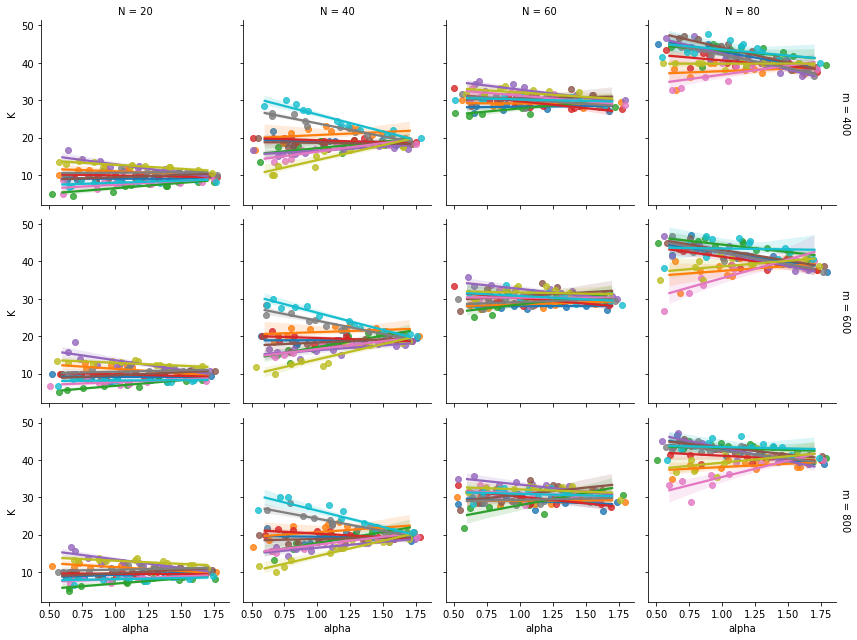

In [122]:
g = sns.FacetGrid(data4, col = "N", row = "m", hue = "try", margin_titles=True)
g.map(sns.regplot, "alpha", "K", fit_reg=True, x_jitter=.1)
plt.show()

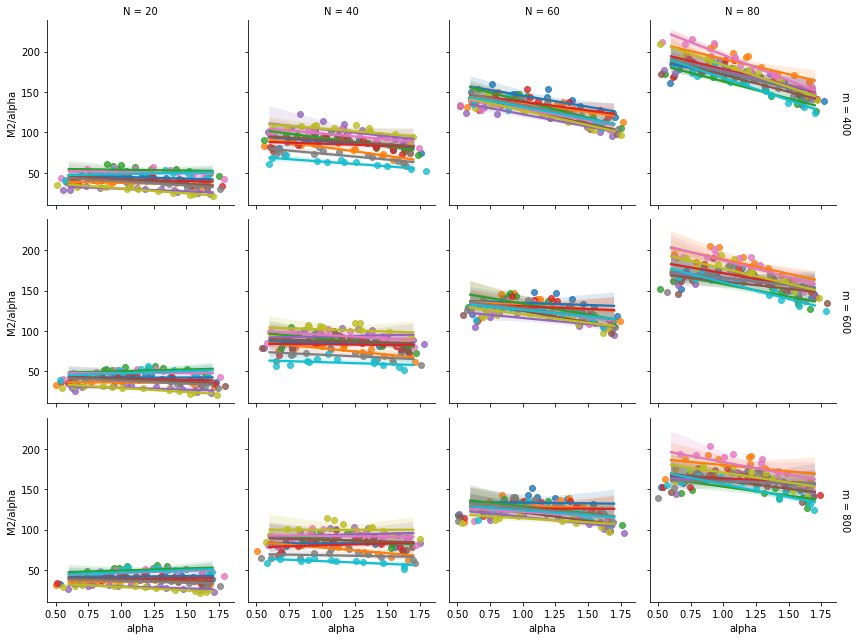

In [27]:
g = sns.FacetGrid(data4, col = "N", row = "m", hue = "try", margin_titles=True)
g.map(sns.regplot, "alpha", "M2/alpha", fit_reg=True, x_jitter=.1)
plt.show()

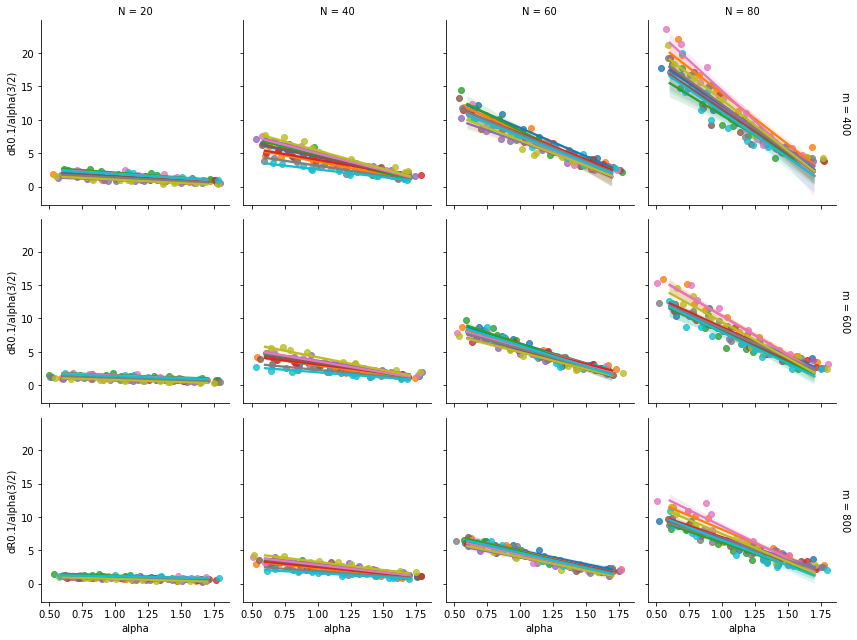

In [33]:
g = sns.FacetGrid(data4, col = "N", row = "m", hue = "try", margin_titles=True)
g.map(sns.regplot, "alpha", "dR0.1/alpha(3/2)", fit_reg=True, x_jitter=.1)
plt.show()

## Part 2: IRL data

In [13]:
data = pd.read_csv("C:/Users\Arthur\Desktop\Study\Fall2022\stat learn\IRL data\Data_for_UCI_named.csv", sep = ',')
data

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.930406,9.487627,2.376523,6.187797,3.343416,-0.658054,-1.449106,-1.236256,0.601709,0.779642,0.813512,0.608385,0.023892,unstable
9996,3.392299,1.274827,2.954947,6.894759,4.349512,-1.663661,-0.952437,-1.733414,0.502079,0.567242,0.285880,0.366120,-0.025803,stable
9997,2.364034,2.842030,8.776391,1.008906,4.299976,-1.380719,-0.943884,-1.975373,0.487838,0.986505,0.149286,0.145984,-0.031810,stable
9998,9.631511,3.994398,2.757071,7.821347,2.514755,-0.966330,-0.649915,-0.898510,0.365246,0.587558,0.889118,0.818391,0.037789,unstable


In [134]:
data_r = data.drop(columns = ["stabf", "stab"])
y = data["stab"]

In [135]:
c_data = data_r - data_r.mean()
cn_data = c_data/(c_data.max() - c_data.min())
cn_data = cn_data/cn_data.std()
n_y = y/y.std()

In [16]:
n_y.describe()

count    10000.000000
mean         0.426092
std          1.000000
min         -2.187487
25%         -0.421379
50%          0.464305
75%          1.215591
max          2.963328
Name: stab, dtype: float64

In [17]:
cn_data.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,5.022177e-15,-1.002642e-15,-7.240042e-16,4.987344e-15,2.566381e-14,-1.801947e-16,-8.872891e-15,-1.031493e-14,5.021317e-15,1.059299e-14,4.266587e-17,3.692291e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.731677e+00,-1.731914e+00,-1.731679e+00,-1.731788e+00,-2.881581e+00,-1.731709e+00,-1.731834e+00,-1.731792e+00,-1.731927e+00,-1.731773e+00,-1.731771e+00,-1.731862e+00
25%,-8.660224e-01,-8.659321e-01,-8.657936e-01,-8.659977e-01,-7.068976e-01,-8.657526e-01,-8.660396e-01,-8.658879e-01,-8.659020e-01,-8.657954e-01,-8.659345e-01,-8.660035e-01
50%,1.437099e-06,-7.205297e-06,-9.092850e-06,-9.587524e-05,1.363379e-03,7.890031e-05,5.874023e-05,-1.736309e-05,3.412506e-05,1.053271e-05,5.233635e-05,5.628881e-06
75%,8.658698e-01,8.659435e-01,8.659624e-01,8.659225e-01,7.078549e-01,8.660351e-01,8.658805e-01,8.658309e-01,8.657439e-01,8.659464e-01,8.657638e-01,8.657382e-01
max,1.731772e+00,1.731906e+00,1.731763e+00,1.731759e+00,2.811128e+00,1.731713e+00,1.731794e+00,1.731904e+00,1.731733e+00,1.731761e+00,1.731898e+00,1.731710e+00


In [18]:
X = np.array(cn_data)
Y = np.array(n_y).reshape((-1,1))

In [216]:
data6 = {"N":[], "try":[], "alpha":[], "m":[], "Lam":[], "dR0.1":[], "dR0.3":[], "dR0.5":[], "DevMax":[]}

rs = 1 - np.array([0.05, 0.10, 0.15, 0.20, 0.25])
alpha = [0.05, 0.10, 0.15, 0.20, 0.25]
Ns = [2, 4, 6, 8, 10]
t = 10
k = 100


for N in Ns:
    
    feature_subsets = set()
    while len(feature_subsets) < t:
        feature_subsets.add(tuple(random.sample(list(cn_data.keys()), N)))
    j = 0
    for feature_subset in feature_subsets:
        j+=1
        temp_data = pd.DataFrame()
        for feature in feature_subset:
            temp_data[feature] = cn_data[feature]
            
        X = np.array(temp_data)
        Y = n_y
        
            
        for a in alpha:
            mod = Lasso(a)
            for r in rs:
                nz = []
                M = np.zeros(k)
                dR = np.zeros(k)
                for i in range(k):
                    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=r)
                    mod.fit(X_train, Y_train)
                    Y_hat = mod.predict(X_test)
                    Y_h = mod.predict(X_train)
                    dR[i] = (mean_squared_error(Y_hat, Y_test) - mean_squared_error(Y_h, Y_train))
                    nz.append(np.count_nonzero(mod.coef_))
                    M[i] = np.max(np.abs(mod.predict(X)-Y))
                data6["N"].append(N)
                data6["try"].append(j)
                data6["alpha"].append(a)
                data6["m"].append(r)
                data6["Lam"].append(np.max(nz))
                data6["dR0.1"].append(np.quantile(dR, 0.9))
                data6["dR0.3"].append(np.quantile(dR, 0.7))
                data6["dR0.5"].append(np.quantile(dR, 0.5))
                data6["DevMax"].append(np.max(M))
     

In [217]:
data6 = pd.DataFrame(data6)
data6["m"] = 1 - data6["m"]
data6

,N,try,alpha,m,Lam,dR0.1,dR0.3,dR0.5,DevMax
0,2,1,0.05,0.05,2,0.072242,0.035162,0.013632,3.004876
1,2,1,0.05,0.10,2,0.036346,0.010331,-0.006905,2.929694
2,2,1,0.05,0.15,2,0.035654,0.019050,-0.001402,2.927766
3,2,1,0.05,0.20,2,0.031828,0.012846,0.000220,2.910400
4,2,1,0.05,0.25,2,0.027641,0.010234,-0.004141,2.916735
...,...,...,...,...,...,...,...,...,...
1245,10,10,0.25,0.05,6,0.074598,0.049818,0.017735,2.763193
1246,10,10,0.25,0.10,6,0.051671,0.027883,0.006424,2.793564
1247,10,10,0.25,0.15,6,0.042284,0.019445,0.006356,2.641155
1248,10,10,0.25,0.20,6,0.033811,0.012809,0.003060,2.636373


In [218]:
data6["dR0.1*srm"] = data6["dR0.1"]*np.sqrt(data6["m"])
data6["dR0.3*srm"] = data6["dR0.3"]*np.sqrt(data6["m"])
data6["dR0.5*srm"] = data6["dR0.5"]*np.sqrt(data6["m"])

data6["dR0.1*m"] = data6["dR0.1"]*data6["m"]
data6["dR0.3*m"] = data6["dR0.3"]*data6["m"]
data6["dR0.5*m"] = data6["dR0.5"]*data6["m"]

data6["DevMax*m(1/4)"] = data6["DevMax"]*(data6["m"]**(1/4))

data6["Lam/N"] = data6["Lam"]/data6["N"]
data6["DevMax2/N"] = (data6["DevMax"]**2)/data6["N"]

data6["dR0.1/[N(3/2)sr(logN)]"] = data6["dR0.1"]/data6["N"]/np.sqrt(data6["N"]*np.log(data6["N"]))
data6["dR0.3/[N(3/2)sr(logN)]"] = data6["dR0.3"]/data6["N"]/np.sqrt(data6["N"]*np.log(data6["N"]))
data6["dR0.5/[N(3/2)sr(logN)]"] = data6["dR0.5"]/data6["N"]/np.sqrt(data6["N"]*np.log(data6["N"]))

data6["dR0.1/Lam"] = data6["dR0.1"]/data6["Lam"]
data6["dR0.3/Lam"] = data6["dR0.3"]/data6["Lam"]
data6["dR0.5/Lam"] = data6["dR0.5"]/data6["Lam"]

data6["DevMax2/Lam"] = (data6["DevMax"]**2)/data6["Lam"]
data6["dR0.1/alpha(3/2)"] = data6["dR0.1"]/np.sqrt(data6["alpha"]**3)

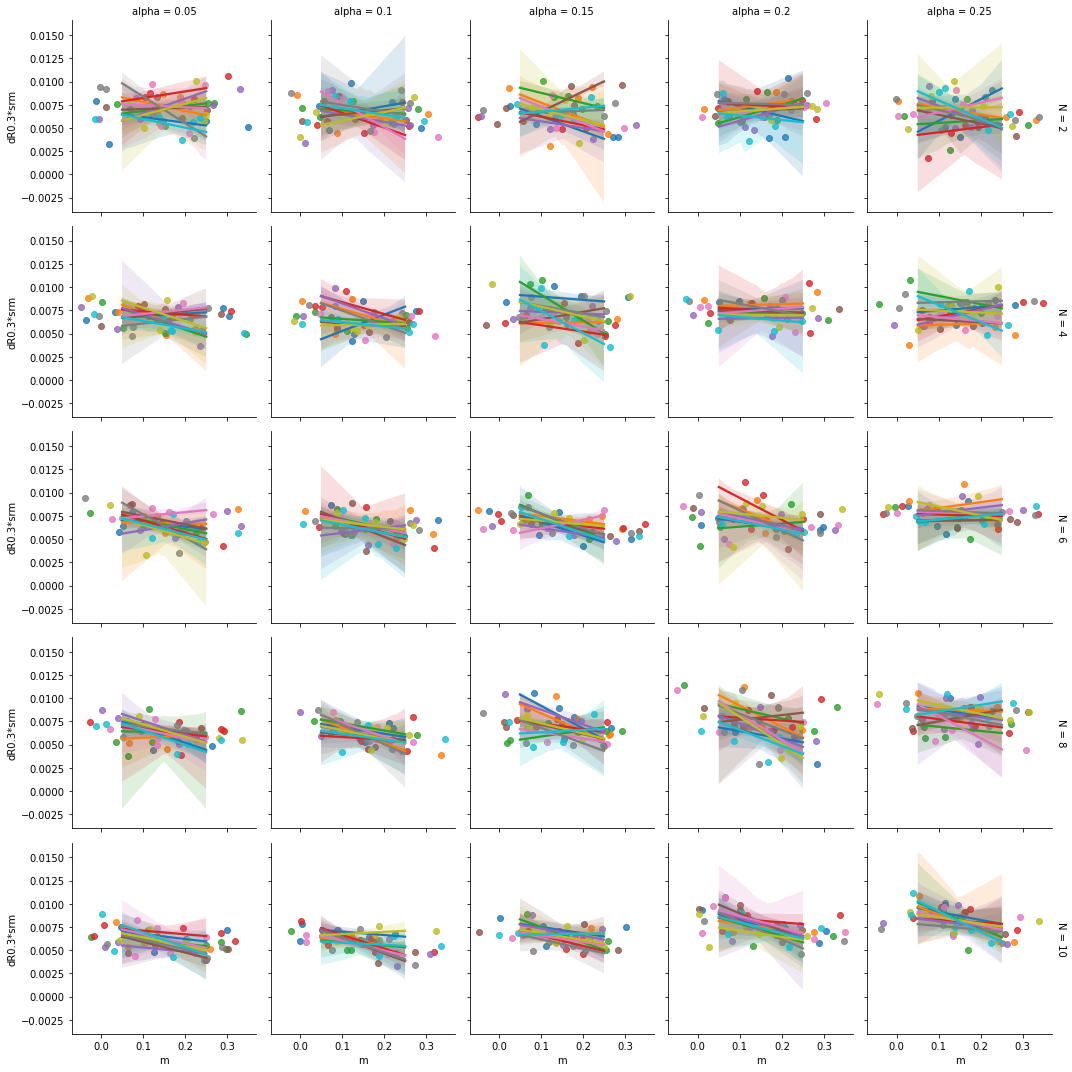

In [219]:
g = sns.FacetGrid(data6, row = "N", col="alpha", margin_titles=True, hue = "try")
g.map(sns.regplot, "m", "dR0.3*srm", fit_reg=True, x_jitter=.1)
plt.show()

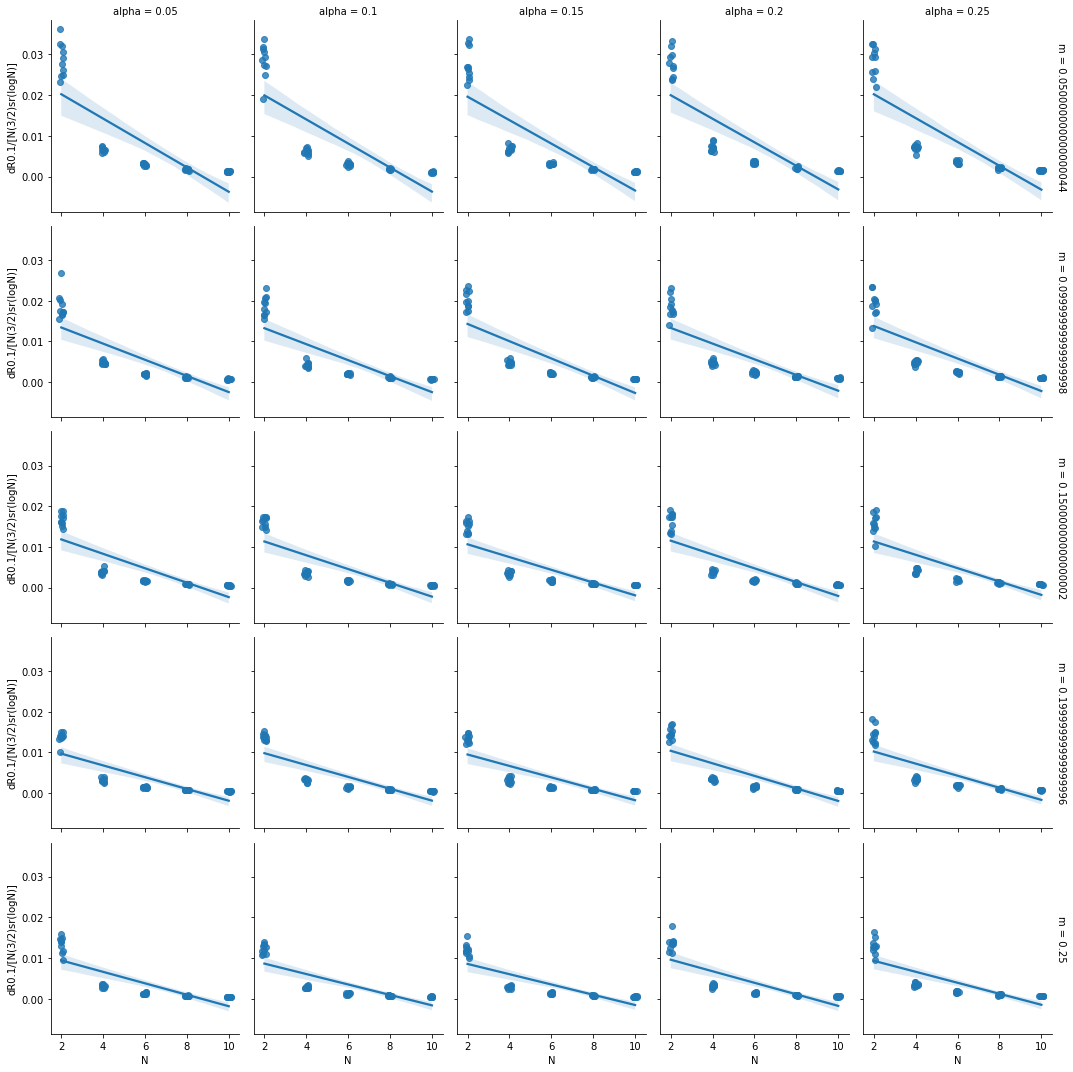

In [220]:
g = sns.FacetGrid(data6, row="m", col="alpha", margin_titles=True)
g.map(sns.regplot, "N", "dR0.1/[N(3/2)sr(logN)]", fit_reg=True, x_jitter=.1)
plt.show()

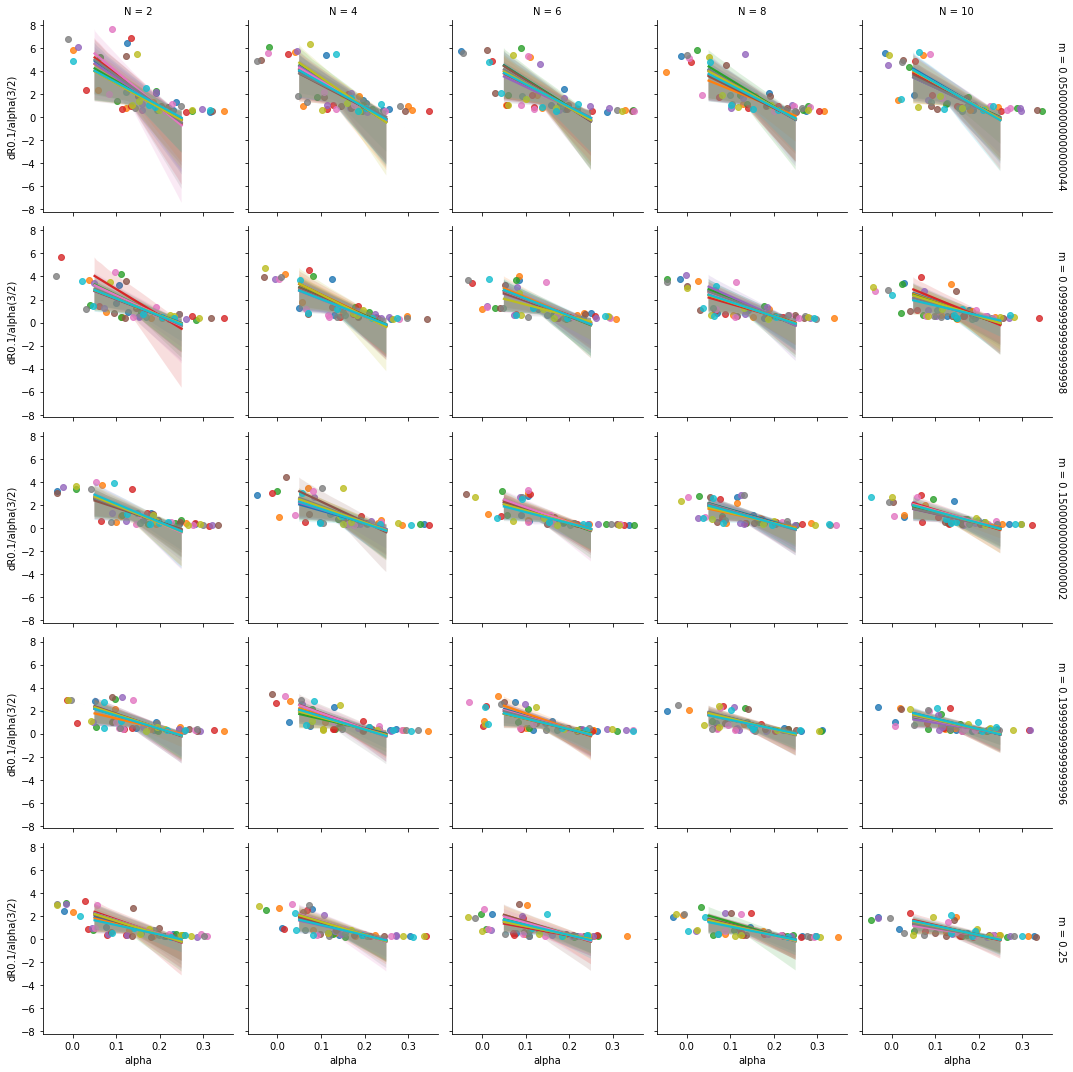

In [221]:
g = sns.FacetGrid(data6, col = "N", row = "m", hue = "try", margin_titles=True)
g.map(sns.regplot, "alpha", "dR0.1/alpha(3/2)", fit_reg=True, x_jitter=.1)
plt.show()